# **Exploratory Data Analysis**

In [1]:
!pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 46.5 MB/s eta 0:00:00


**Dataset Cleaning**

In [1]:
import pandas as pd

# Step 1: Read the file as raw text
with open("chemfile.csv", "r", encoding="utf-8", errors="ignore") as f:
    raw_data = f.read()

# Step 2: Replace multiple quotes and clean formatting
raw_data = raw_data.replace('""', '"').replace('"', '')

# Step 3: Save cleaned text back to a temporary file
with open("chemfile_clean.csv", "w", encoding="utf-8") as f:
    f.write(raw_data)

# Step 4: Now load with pandas using semicolon separator
df = pd.read_csv("chemfile_clean.csv", sep=";", engine="python", on_bad_lines="skip")

# Step 5: Clean column names
df.columns = df.columns.str.strip()

# Preview
print("✅ Columns:", df.columns.tolist())
print(df.head(5))

#  Save properly for future use
df.to_excel("chemfile_finalclean.xlsx", index=False)
print(df.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'chemfile.csv'

**Selecting Essential Columns**

In [3]:

# Select only essential columns
keep_cols = [
    "Molecule ChEMBL ID",
    "Molecule Name",
    "Smiles",
    "Standard Relation",
    "Standard Value"
]

df = df[keep_cols]

# Preview
print("✅ Final Columns:", df.columns.tolist())
print(df.head(10))

# Save final dataset
df.to_csv("chemfile_with specific cols.csv", index=False)

print(df.shape)


✅ Final Columns: ['Molecule ChEMBL ID', 'Molecule Name', 'Smiles', 'Standard Relation', 'Standard Value']
  Molecule ChEMBL ID  Molecule Name  \
0      CHEMBL4113879            NaN   
1      CHEMBL3935725            NaN   
2      CHEMBL3968328            NaN   
3      CHEMBL2042132            NaN   
4          CHEMBL576  SUCCINIC ACID   
5      CHEMBL2443116            NaN   
6      CHEMBL2443218            NaN   
7      CHEMBL2042128            NaN   
8      CHEMBL2443130            NaN   
9      CHEMBL2443216            NaN   

                                              Smiles Standard Relation  \
0  N#Cc1nc(C(=O)N[C@H](Cc2ccccc2)[C@@H](O)C(=O)O)...               '='   
1           O=C(O)CCNC(=O)c1ncc2cc(Oc3cccnc3)ccc2c1O               '='   
2   COc1ccc(Oc2ccc3c(O)c(C(=O)NCCCCC(=O)O)ncc3c2)cc1               '='   
3  CC(C)c1ccc2c(c1)C1(CCN(Cc3nccn3C)CC1)C(=O)N2c1...               '='   
4                                     O=C(O)CCC(=O)O               '>'   
5  Cc1cccnc1CN1CCC2(

**Handle duplicate through canonical smiles**

In [4]:
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt

# =====================
# Step 1: Read and clean raw CSV
# =====================
with open("chemfile.csv", "r", encoding="utf-8", errors="ignore") as f:
    raw_data = f.read()

raw_data = raw_data.replace('""', '"').replace('"', '')

with open("chemfile_clean.csv", "w", encoding="utf-8") as f:
    f.write(raw_data)

df = pd.read_csv("chemfile_clean.csv", sep=";", engine="python", on_bad_lines="skip")

# =====================
# Step 2: Keep only required columns
# =====================
keep_cols = [
    "Molecule ChEMBL ID",
    "Molecule Name",
    "Smiles",
    "Standard Relation",
    "Standard Value",
    "Standard Units",
    "Molecular Weight"
]
df = df[keep_cols]

# =====================
# Step 3: Normalize values
# =====================
# Clean relation column (remove spaces and quotes)
df["Standard Relation"] = (
    df["Standard Relation"]
    .astype(str)
    .str.strip()
    .str.replace('"', '', regex=False)
    .str.replace("'", '', regex=False)
)

# Convert values to nM
df["Value_nM"] = pd.to_numeric(df["Standard Value"], errors="coerce")

# =====================
# Step 4: Binding classification
# =====================
rule_counters = {
    "binder_=": 0,
    "nonbinder_=": 0,
    "binder_<": 0,
    "other_<": 0,
    "nonbinder_>": 0,
    "other_>": 0,
    "other_misc": 0
}

def classify_binding(value_nM, relation):
    if pd.isna(value_nM):
        rule_counters["other_misc"] += 1
        return "other"

    threshold = 2000  # 2 µM = 2000 nM
    rel = str(relation).strip()

    # ===== "=" =====
    if rel == "=":
        if value_nM < threshold:
            rule_counters["binder_="] += 1
            return "binder"
        elif value_nM == threshold:
            rule_counters["nonbinder_="] += 1
            return "non-binder"
        else:
            rule_counters["nonbinder_="] += 1
            return "non-binder"

    # ===== ">" =====
    elif rel == ">":
        if value_nM > 100_000:
            rule_counters["nonbinder_>"] += 1
            return "non-binder"
        elif value_nM > threshold:
            rule_counters["other_>"] += 1
            return "other"
        else:
            rule_counters["other_>"] += 1
            return "other"

    # ===== "<" =====
    elif rel == "<":
        if value_nM < threshold:
            rule_counters["binder_<"] += 1
            return "binder"
        elif value_nM < 10_000:
            rule_counters["other_<"] += 1
            return "other"
        else:
            rule_counters["other_<"] += 1
            return "other"

    rule_counters["other_misc"] += 1
    return "other"

df["Binding_Class"] = df.apply(
    lambda r: classify_binding(r["Value_nM"], r["Standard Relation"]), axis=1
)

# =====================
# Step 5: Canonicalize SMILES & handle duplicates
# =====================
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None
    return None

df["Canonical_SMILES"] = df["Smiles"].astype(str).apply(canonicalize_smiles)
df = df.dropna(subset=["Canonical_SMILES"])

priority_map = {"binder": 0, "other": 1, "non-binder": 2}
df["Priority"] = df["Binding_Class"].map(priority_map)
df = df.sort_values(by=["Canonical_SMILES", "Priority"])
df = df.drop_duplicates(subset=["Canonical_SMILES"], keep="first").drop(columns=["Priority"])

# =====================
# Step 6: Reporting
# =====================
print("\n===== 📊 FINAL CLASS DISTRIBUTION =====")
print(df["Binding_Class"].value_counts())

print("\n===== 🧮 RULE COUNTERS (how compounds were classified) =====")
for k, v in rule_counters.items():
    print(f"{k}: {v}")

print("\n✅ Example classified compounds:")
print(df[["Standard Value", "Standard Units", "Standard Relation", "Value_nM", "Binding_Class"]].head(15))




===== 📊 FINAL CLASS DISTRIBUTION =====
Binding_Class
binder        613
non-binder    519
other         138
Name: count, dtype: int64

===== 🧮 RULE COUNTERS (how compounds were classified) =====
binder_=: 774
nonbinder_=: 623
binder_<: 33
other_<: 1
nonbinder_>: 48
other_>: 81
other_misc: 153

✅ Example classified compounds:
      Standard Value Standard Units Standard Relation   Value_nM Binding_Class
235              1.9             nM                 =        1.9        binder
747         100000.0             nM                 >   100000.0         other
400         100000.0             nM                 >   100000.0         other
548        1000000.0             nM                 >  1000000.0    non-binder
1229           440.0             nM                 =      440.0        binder
769         100000.0             nM                 >   100000.0         other
757            800.0             nM                 =      800.0        binder
87          134000.0             nM      

**PLOTTING WITH UPDATED MOLECULAR WEIGHT <700**

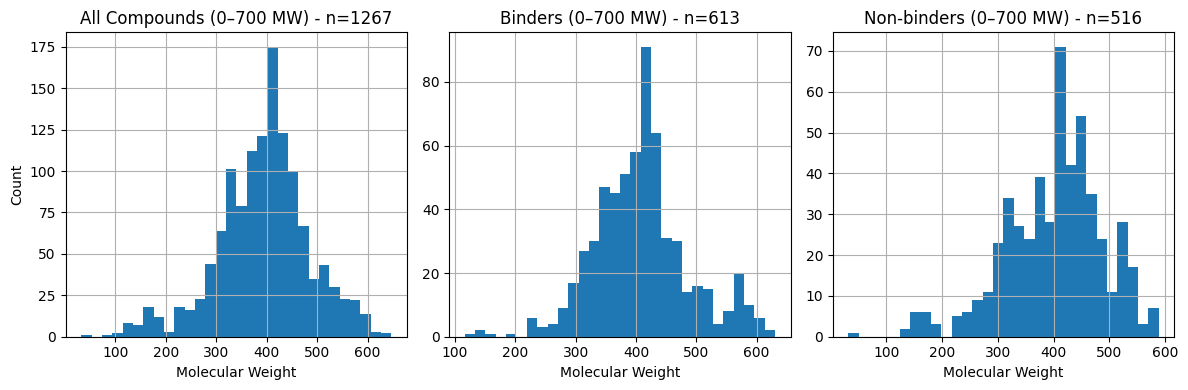

In [5]:
# =====================
# Step 7: Plot distributions (with MW filter)
# =====================

plt.figure(figsize=(12, 4))

# All compounds (MW 0–700 only)
plt.subplot(1, 3, 1)
df[df["Molecular Weight"].between(0, 700)]["Molecular Weight"].hist(bins=30)
plt.title(f"All Compounds (0–700 MW) - n={len(df[df['Molecular Weight'].between(0, 700)])}")
plt.xlabel("Molecular Weight")
plt.ylabel("Count")

# Binders (MW 0–700 only)
plt.subplot(1, 3, 2)
binder_df = df[(df["Binding_Class"] == "binder") & (df["Molecular Weight"].between(0, 700))]
if not binder_df.empty:
    binder_df["Molecular Weight"].hist(bins=30)
plt.title(f"Binders (0–700 MW) - n={len(binder_df)}")
plt.xlabel("Molecular Weight")

# Non-binders (MW 0–700 only)
plt.subplot(1, 3, 3)
nonbinder_df = df[(df["Binding_Class"] == "non-binder") & (df["Molecular Weight"].between(0, 700))]
if not nonbinder_df.empty:
    nonbinder_df["Molecular Weight"].hist(bins=30)
plt.title(f"Non-binders (0–700 MW) - n={len(nonbinder_df)}")
plt.xlabel("Molecular Weight")

plt.tight_layout()
plt.show()



🔎 Molecular weight filter applied: kept 1708 compounds out of 1713
❌ Removed 5 compounds outside 0–700 MW range

===== 📊 FINAL CLASS DISTRIBUTION =====
Binding_Class
binder        613
non-binder    516
other         138
Name: count, dtype: int64

===== 🧮 RULE COUNTERS (how compounds were classified) =====
binder_=: 774
nonbinder_=: 618
binder_<: 33
other_<: 1
nonbinder_>: 48
other_>: 81
other_misc: 153

✅ Example classified compounds:
      Standard Value Standard Units Standard Relation   Value_nM Binding_Class
235              1.9             nM                 =        1.9        binder
747         100000.0             nM                 >   100000.0         other
400         100000.0             nM                 >   100000.0         other
548        1000000.0             nM                 >  1000000.0    non-binder
1229           440.0             nM                 =      440.0        binder
769         100000.0             nM                 >   100000.0         other
757    

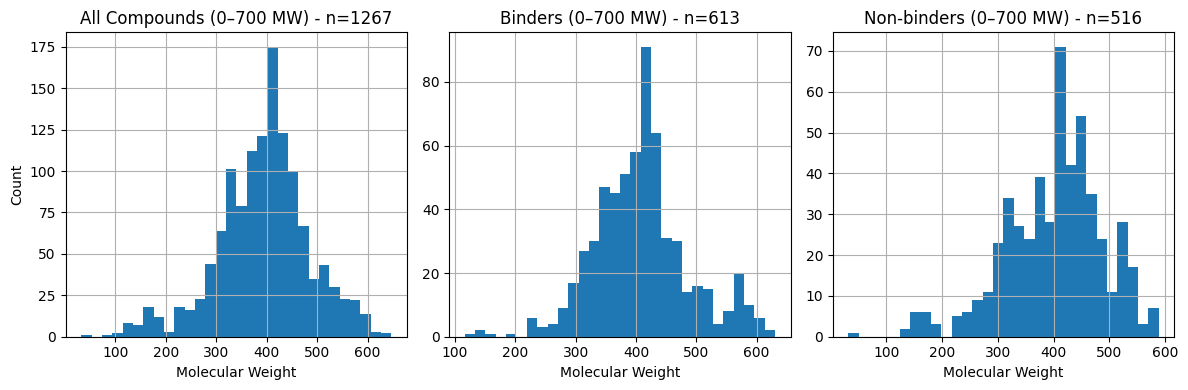

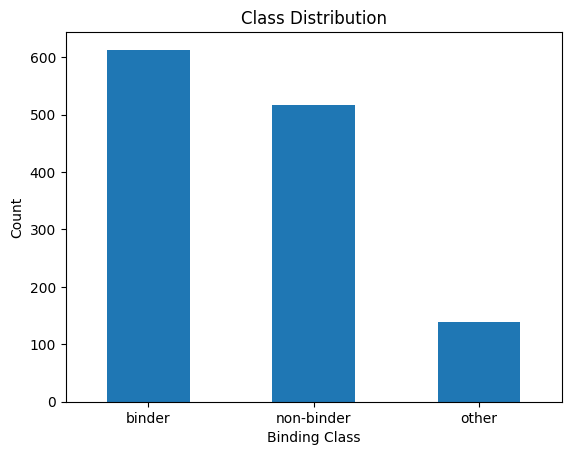

In [6]:
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt

# =====================
# Step 1: Read and clean raw CSV
# =====================
with open("chemfile.csv", "r", encoding="utf-8", errors="ignore") as f:
    raw_data = f.read()

raw_data = raw_data.replace('""', '"').replace('"', '')

with open("chemfile_clean.csv", "w", encoding="utf-8") as f:
    f.write(raw_data)

df = pd.read_csv("chemfile_clean.csv", sep=";", engine="python", on_bad_lines="skip")

# =====================
# Step 2: Keep only required columns
# =====================
keep_cols = [
    "Molecule ChEMBL ID",
    "Molecule Name",
    "Smiles",
    "Standard Relation",
    "Standard Value",
    "Standard Units",
    "Molecular Weight"
]
df = df[keep_cols]

# =====================
# Step 2.1: Filter Molecular Weight between 0 and 700
# =====================
df["Molecular Weight"] = pd.to_numeric(df["Molecular Weight"], errors="coerce")

before_count = len(df)
df = df[df["Molecular Weight"].between(0, 700)]
after_count = len(df)

print(f"\n🔎 Molecular weight filter applied: kept {after_count} compounds out of {before_count}")
print(f"❌ Removed {before_count - after_count} compounds outside 0–700 MW range")

# =====================
# Step 3: Normalize values
# =====================
df["Standard Relation"] = (
    df["Standard Relation"]
    .astype(str)
    .str.strip()
    .str.replace('"', '', regex=False)
    .str.replace("'", '', regex=False)
)

df["Value_nM"] = pd.to_numeric(df["Standard Value"], errors="coerce")

# =====================
# Step 4: Binding classification
# =====================
rule_counters = {
    "binder_=": 0,
    "nonbinder_=": 0,
    "binder_<": 0,
    "other_<": 0,
    "nonbinder_>": 0,
    "other_>": 0,
    "other_misc": 0
}

def classify_binding(value_nM, relation):
    if pd.isna(value_nM):
        rule_counters["other_misc"] += 1
        return "other"

    threshold = 2000  # 2 µM = 2000 nM
    rel = str(relation).strip()

    if rel == "=":
        if value_nM < threshold:
            rule_counters["binder_="] += 1
            return "binder"
        else:
            rule_counters["nonbinder_="] += 1
            return "non-binder"

    elif rel == ">":
        if value_nM > 100_000:
            rule_counters["nonbinder_>"] += 1
            return "non-binder"
        else:
            rule_counters["other_>"] += 1
            return "other"

    elif rel == "<":
        if value_nM < threshold:
            rule_counters["binder_<"] += 1
            return "binder"
        else:
            rule_counters["other_<"] += 1
            return "other"

    rule_counters["other_misc"] += 1
    return "other"

df["Binding_Class"] = df.apply(
    lambda r: classify_binding(r["Value_nM"], r["Standard Relation"]), axis=1
)

# =====================
# Step 5: Canonicalize SMILES & handle duplicates
# =====================
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
    except:
        return None
    return None

df["Canonical_SMILES"] = df["Smiles"].astype(str).apply(canonicalize_smiles)
df = df.dropna(subset=["Canonical_SMILES"])

priority_map = {"binder": 0, "other": 1, "non-binder": 2}
df["Priority"] = df["Binding_Class"].map(priority_map)
df = df.sort_values(by=["Canonical_SMILES", "Priority"])
df = df.drop_duplicates(subset=["Canonical_SMILES"], keep="first").drop(columns=["Priority"])

# =====================
# Step 6: Reporting
# =====================
print("\n===== 📊 FINAL CLASS DISTRIBUTION =====")
print(df["Binding_Class"].value_counts())

print("\n===== 🧮 RULE COUNTERS (how compounds were classified) =====")
for k, v in rule_counters.items():
    print(f"{k}: {v}")

print("\n✅ Example classified compounds:")
print(df[["Standard Value", "Standard Units", "Standard Relation", "Value_nM", "Binding_Class"]].head(15))

# =====================
# Step 7: Plot distributions (MW 0–700 only)
# =====================
plt.figure(figsize=(12, 4))

# All compounds
plt.subplot(1, 3, 1)
df["Molecular Weight"].hist(bins=30)
plt.title(f"All Compounds (0–700 MW) - n={len(df)}")
plt.xlabel("Molecular Weight")
plt.ylabel("Count")

# Binders
plt.subplot(1, 3, 2)
binder_df = df[df["Binding_Class"] == "binder"]
if not binder_df.empty:
    binder_df["Molecular Weight"].hist(bins=30)
plt.title(f"Binders (0–700 MW) - n={len(binder_df)}")
plt.xlabel("Molecular Weight")

# Non-binders
plt.subplot(1, 3, 3)
nonbinder_df = df[df["Binding_Class"] == "non-binder"]
if not nonbinder_df.empty:
    nonbinder_df["Molecular Weight"].hist(bins=30)
plt.title(f"Non-binders (0–700 MW) - n={len(nonbinder_df)}")
plt.xlabel("Molecular Weight")

plt.tight_layout()
plt.show()

# 📊 Extra: Bar chart of class counts
df["Binding_Class"].value_counts().plot(kind="bar", rot=0, title="Class Distribution")
plt.xlabel("Binding Class")
plt.ylabel("Count")
plt.show()

# =====================
# Step 8: Save final datasets
# =====================

# File 1: All classes (others + binders + non-binders)
df.to_csv("chemfile_final_all_classes.csv", index=False)

# File 2: Only binders + non-binders
df_binary = df[df["Binding_Class"].isin(["binder", "non-binder"])]
df_binary.to_csv("chemfile_final_binders_nonbinders.csv", index=False)



# **final datasets**

In [7]:
# =====================
# Remove unwanted fragments from SMILES
# =====================
unwanted_patterns = [".C", ".Cl", ".NA+", ".Na+", ".na+", "[Na+]", "Cl.", ".O=C(O)C(F)(F)F"]

def contains_unwanted(smiles):
    if pd.isna(smiles):
        return False
    return any(pattern in smiles for pattern in unwanted_patterns)

before_clean = len(df)
df = df[~(df["Smiles"].apply(contains_unwanted) | df["Canonical_SMILES"].apply(contains_unwanted))]
after_clean = len(df)

print(f"\n🧹 Removed {before_clean - after_clean} compounds containing salts/fragments (.C, .Cl, .Na+)")

# =====================
# Step 8: Save final datasets
# =====================
df.to_csv("chemfile_final_all_classes.csv", index=False)

df_binary = df[df["Binding_Class"].isin(["binder", "non-binder"])]
df_binary.to_csv("chemfile_final_binders_nonbinders.csv", index=False)

print("\n💾 Saved two files:")
print("1. final_all_classes.csv (others, binders, non-binders)")
print("2. final_binders_nonbinders.csv (binders, non-binders)")



🧹 Removed 17 compounds containing salts/fragments (.C, .Cl, .Na+)

💾 Saved two files:
1. final_all_classes.csv (others, binders, non-binders)
2. final_binders_nonbinders.csv (binders, non-binders)
